![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Welcome to MuJoCo Playground! <a href="https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/welcome_to_the_playground.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a>

Welcome to MuJoCo Playground, we're excited to meet you! MuJoCo Playground contains a comprehensive suite of environments for reinforcement learning and robotics research. In this notebook, we'll give a tour of [DM Control Suite](https://github.com/google-deepmind/dm_control/tree/main/dm_control/suite) environments that were ported to run on GPU via [MJX](https://mujoco.readthedocs.io/en/stable/mjx.html).

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".


In [ ]:
#@title Install pre-requisites
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

In [1]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Thu Feb 20 18:01:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:4B:00.0 Off |                  Off |
|  0%   32C    P3             52W /  450W |     443MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# @title Import packages for plotting and creating graphics
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
print("Installing mediapy:")
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [3]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

# Intro

MuJoCo Playground contains environments for DM Control Suite, Robotic Locomotion, and Robotic Manipulation. You can load any of these environments via the environment registry:

In [4]:
from mujoco_playground import registry
env_cfg = registry.get_default_config('CartpoleBalance_CyberSpine')
env = registry.load('CartpoleBalance_CyberSpine')
# env = registry.load('HumanoidWalkCyberSpine')
env

🔹 Loading existing J from J.npy
Initializing with action_size=1, muscle_activity_size=10
Caution: Reset csp1 params !!!!
Caution: Reset CC params !!!!
Initializing with action_size=1, muscle_activity_size=10


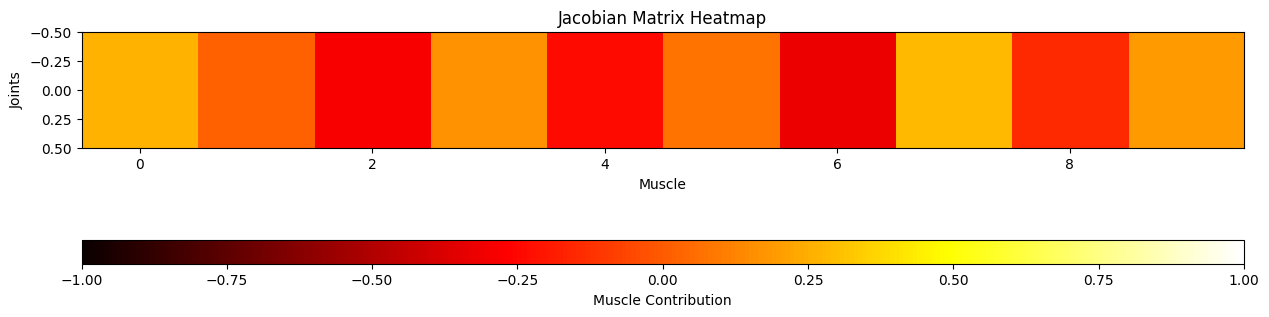

In [5]:
## Visualize J
import numpy as np
import matplotlib.colors as mcolors

# 加载 J.npy
J = np.load("J.npy")

# 创建一个掩蔽矩阵，零值掩蔽为白色
masked_J = np.ma.masked_equal(J, 0)

# 创建一个自定义的颜色图
cmap = plt.cm.hot
cmap.set_under('lightgray')  # 设置低于最小值（即零值）的颜色为灰色

# 调整 figure 的大小，使其更适合矩阵的形状
plt.figure(figsize=(15, 12))

# 创建热图，使用掩蔽矩阵，并设置颜色
im = plt.imshow(masked_J, cmap=cmap, interpolation='nearest', vmax=1, vmin=-1)  # 设定最小显示值

# 添加标签和标题
plt.title('Jacobian Matrix Heatmap')
plt.xlabel('Muscle')
plt.ylabel('Joints')

# 显示横向的 colorbar
cbar = plt.colorbar(im, orientation='horizontal', pad=0.1, aspect=50)  # 设置横向，调整大小
cbar.set_label('Muscle Contribution')  # 为 colorbar 添加标签

# 显示热图
plt.show()


In [8]:
# 确定每个肌肉列的主要关节（行）
main_joints = np.argmax(np.abs(J), axis=0)

# 创建一个字典，将列索引按主要关节分组
joint_to_columns = {}
for col, joint in enumerate(main_joints):
    joint_to_columns.setdefault(joint, []).append(col)

# 根据行的顺序重新排列列索引
sorted_columns = []
for joint in sorted(joint_to_columns.keys()):
    sorted_columns.extend(joint_to_columns[joint])

# 重新排列 J 的列，生成 J_rearrange
J_rearrange = J[:, sorted_columns]

# 保存结果
# np.save('J_rearrange.npy', J_rearrange)

In [ ]:
# 创建一个掩蔽矩阵，零值掩蔽为白色
masked_J = np.ma.masked_equal(J_rearrange, 0)

# 创建一个自定义的颜色图
cmap = plt.cm.hot
cmap.set_under('lightgray')  # 设置低于最小值（即零值）的颜色为灰色

# 调整 figure 的大小，使其更适合矩阵的形状
plt.figure(figsize=(15, 12))

# 创建热图，使用掩蔽矩阵，并设置颜色
im = plt.imshow(masked_J, cmap=cmap, interpolation='nearest', vmax=1, vmin=-1)  # 设定最小显示值

# 添加标签和标题
plt.title('Jacobian Matrix Heatmap')
plt.xlabel('Muscle')
plt.ylabel('Joints')

# 显示横向的 colorbar
cbar = plt.colorbar(im, orientation='horizontal', pad=0.1, aspect=50)  # 设置横向，调整大小
cbar.set_label('Muscle Contribution')  # 为 colorbar 添加标签

# 显示热图
plt.show()

Each environment is also associated with an environment config, which can be overriden if so desired. Let's also load the config:

Notice that the environment config contains `sim_dt` and `ctrl_dt`. Each simulation step runs with a timestep of `sim_dt`. `ctrl_dt` determines how much time passes by for each `env.step`. Thus every `env.step` will step the simulation `ctrl_dt / sim_dt` times.

Other parameters worth noting are `vision_config`, which we discuss more about in the vision-based notebooks! For now, we'll stick to privileged observations.

# Rollout

Let's now do a simple rollout. This follows closely with the [MJX tutorial notebook](https://colab.sandbox.google.com/github/google-deepmind/mujoco/blob/main/mjx/tutorial.ipynb). If you're familiar with MJX, this should be familiar; otherwise feel free to checkout out the MJX tutorial first!

In [5]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_train_step = jax.jit(env.train_step)
# jit_reset_buffer = jax.jit(env.reset_buffer)

In [6]:
state = jit_reset(jax.random.PRNGKey(0))
# state = env.reset(jax.random.PRNGKey(0))
rollout = [state]
loss_history = []

f = 0.5
for i in range(env_cfg.episode_length):
  action = []
  for j in range(env.action_size):
    action.append(
        jp.sin(
            state.data.time * 2 * jp.pi * f + j * 2 * jp.pi / env.action_size
        )
    )
  action = jp.array(action)

  print(f"buffer_size_before_jit_step: {len(state.buffer)}")
  state = jit_step(state, action)
  # state = env.step(state, action)

  # print(f"Length of buffer: {len(env.buffer)}")
  # # 每10步记录一次损失
  # if len(env.cc_loss_history) % 10 == 0:
  #     writer.add_scalar('CC_net_loss', env.cc_loss_history[-1], i)

  print(f"buffer_size_after_jit_step: {len(state.buffer)}")

  # state = env.train_step(state)
 
  loss, state = jit_train_step(state)
  
  if loss is not None:
     loss_history.append(loss) 

  # if len(state.buffer) >= 10:
  #       state = env.train_step(state)  # 调用 train_step() 进行训练
  #       # jit_train_step()  # 调用 train_step() 进行训练
  #       # print(f"Loss after training step: {loss}")
  #       # state = env.reset_buffer(state)
  #       print(f"Reset Buffer:")

  rollout.append(state)

# writer.close()


buffer_size_before_jit_step: 0
Input to dense1: (1,)
Output of dense1: (512,)
Output of dense2: (512,)
Output of network: (10,)
buffer_size_after_jit_step: 1
buffer_size_before_jit_step: 1
Input to dense1: (1,)
Output of dense1: (512,)
Output of dense2: (512,)
Output of network: (10,)
buffer_size_after_jit_step: 2
buffer_size_before_jit_step: 2
Input to dense1: (1,)
Output of dense1: (512,)
Output of dense2: (512,)
Output of network: (10,)
buffer_size_after_jit_step: 3
buffer_size_before_jit_step: 3
Input to dense1: (1,)
Output of dense1: (512,)
Output of dense2: (512,)
Output of network: (10,)
buffer_size_after_jit_step: 4
buffer_size_before_jit_step: 4
Input to dense1: (1,)
Output of dense1: (512,)
Output of dense2: (512,)
Output of network: (10,)
buffer_size_after_jit_step: 5
buffer_size_before_jit_step: 5
Input to dense1: (1,)
Output of dense1: (512,)
Output of dense2: (512,)
Output of network: (10,)
buffer_size_after_jit_step: 6
buffer_size_before_jit_step: 6
Input to dense1: (1,)

In [7]:
len(loss_history)

100

In [8]:

frames = env.render(rollout)
media.show_video(frames, fps=1.0 / env.dt)

100%|██████████| 1001/1001 [00:06<00:00, 144.78it/s]


If you're running the notebook with a GPU instance (which you should), notice that the environment runs and lives on the device! That of course means we can do some large-batch RL on the GPU.

In [9]:
state.obs.device

CudaDevice(id=0)

# RL

We'll use [brax](https://github.com/google/brax) to train some RL policies, but we show examples with [RSL-RL](https://github.com/google-deepmind/mujoco_playground/tree/main/learning/train_rsl_rl.py) in the main repo via [`python train_rsl_rl.py`](). We encourage `pytorch` users to take a look!

For now we'll go ahead with a brax PPO example.



MuJoCo Playground comes with a set of hyper-parameters for all available environments via `mujoco_playground.config`. A selection of environments contain configs for RSL-RL and for vision-based brax PPO. Let's load the brax PPO config for CartpoleBalance!

In [10]:
from mujoco_playground.config import dm_control_suite_params
ppo_params = dm_control_suite_params.brax_ppo_config('CartpoleBalance')
ppo_params

action_repeat: 1
batch_size: 1024
discounting: 0.995
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.001
normalize_observations: true
num_envs: 2048
num_evals: 10
num_minibatches: 32
num_timesteps: 60000000
num_updates_per_batch: 16
reward_scaling: 10.0
unroll_length: 30

And let's of course train a policy!

### Custom Training Process

In [ ]:
import functools
from mujoco_playground import wrapper
from mujoco_playground._src.dm_control_suite import cyber_spine_train

# 自定义训练循环
# 自定义训练循环
def train_with_csp1_and_cc(env, ppo_params, csp1_train_state, cc_train_state, num_epochs=1000):
    times = [datetime.now()]
    
    # 使用PPO的训练函数
    ppo_training_params = dict(ppo_params)
    network_factory = ppo_networks.make_ppo_networks
    if "network_factory" in ppo_params:
        del ppo_training_params["network_factory"]
        network_factory = functools.partial(
            ppo_networks.make_ppo_networks,
            **ppo_params.network_factory
        )

    # 初始化 PPO
    train_fn = functools.partial(
        ppo.train, **dict(ppo_training_params),
        network_factory=network_factory,
    )

    # 初始化 PPO 和获取推理函数
    make_inference_fn, params, metrics = train_fn(
        environment=env,
        wrap_env_fn=wrapper.wrap_for_brax_training,
    )

    # 模拟训练循环
    for epoch in range(num_epochs):
        # 1. 使用PPO进行训练，获得动作、奖励等数据
        action_batch, true_obs_batch = ppo_step()  # 自定义的ppo_step()实现

        # 2. 更新CSP1和CC_net
        # 在每个epoch或每个步骤后更新CSP1和CC_net
        csp1_train_state, cc_train_state, loss = cyber_spine_train.train_step_joint(csp1_train_state, cc_train_state, action_batch, true_obs_batch)

        # 3. 在训练中继续同步PPO策略与CSP1、CC_net的训练
        sync_model_with_ppo(csp1_train_state, cc_train_state)

        # 输出训练信息
        print(f"Epoch {epoch}, Loss: {loss}")

# 用来更新PPO的策略
def ppo_step():
    # 在这里使用PPO的策略更新代码获取action_batch、true_obs_batch等数据
    # 这个步骤可以通过brax提供的train函数生成数据
    action_batch = jp.ones((10, 5))  # 假设生成了一批动作数据
    true_obs_batch = jp.ones((10, 5))  # 假设生成了真实的观察数据
    return action_batch, true_obs_batch

def sync_model_with_ppo(csp1_train_state, cc_train_state):
    # 在这里将CSP1和CC_net的参数与PPO策略进行同步
    # 可以用PPO的网络参数或者状态来更新它们
    # 例如，我们可以把PPO的更新应用到CSP1和CC_net的训练状态中
    # 这个函数的具体实现取决于你如何同步这两个模型
    pass


In [ ]:
# 训练PPO+ CSP1 + CC_net
train_with_csp1_and_cc(env, ppo_params, csp1_train_state, cc_train_state)

### PPO

In [11]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

In [12]:
from mujoco_playground import wrapper

make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

Input to dense1: (1,)
Output of dense1: (512,)
Output of dense2: (512,)
Output of network: (10,)


TypeError: scan body function carry input and carry output must have the same pytree structure, but they differ:

The input carry component state.buffer is a list of length 0 but the corresponding component of the carry output is a list of length 1, so the lengths do not match.

Revise the function so that the carry output has the same pytree structure as the carry input.

If you're familiar with brax, you'll notice that we provided a custom wrapper to the `train_fn`. That's because MuJoCo Playground environments are not compatible with the vanilla brax wrappers. For RSL-RL, we ship wrappers in [`wrapper_torch.py`](https://github.com/google-deepmind/mujoco_playground/tree/main/mujoco_playground/_src/wrapper_torch.py).

## Visualize Rollout

In [11]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

### SAC

In [13]:
from mujoco_playground.config import dm_control_suite_params
sac_params = dm_control_suite_params.brax_sac_config('CartpoleBalance')

In [14]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, sac_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

sac_training_params = dict(sac_params)
network_factory = sac_networks.make_sac_networks
if "network_factory" in sac_params:
  del sac_training_params["network_factory"]
  network_factory = functools.partial(
      sac_networks.make_sac_networks,
      **sac_params.network_factory
  )

train_fn = functools.partial(
    sac.train, **dict(sac_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [16]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(0)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

# DM Control Suite - Take a spin!

Feel free to now take a spin on any of the DM Control Suite environments! The world is your oyster.

In [4]:
env_name = "HumanoidWalk"  # @param ["AcrobotSwingup", 
                        # "AcrobotSwingupSparse", 
                        # "BallInCup", 
                        # "CartpoleBalance", 
                        # "CartpoleBalanceSparse", 
                        # "CartpoleSwingup", 
                        # "CartpoleSwingupSparse", 
                        # "CheetahRun", 
                        # "FingerSpin", 
                        # "FingerTurnEasy", 
                        # "FingerTurnHard", 
                        # "FishSwim", 
                        # "HopperHop", 
                        # "HopperStand", 
                        # "HumanoidStand", 
                        # "HumanoidWalk", 
                        # "HumanoidRun", 
                        # "PendulumSwingup", 
                        # "PointMass", 
                        # "ReacherEasy", 
                        # "ReacherHard", 
                        # "SwimmerSwimmer6", 
                        # "WalkerRun", 
                        # "WalkerStand", 
                        # "WalkerWalk"]
CAMERAS = {
    "AcrobotSwingup": "fixed",
    "AcrobotSwingupSparse": "fixed",
    "BallInCup": "cam0",
    "CartpoleBalance": "fixed",
    "CartpoleBalanceSparse": "fixed",
    "CartpoleSwingup": "fixed",
    "CartpoleSwingupSparse": "fixed",
    "CheetahRun": "side",
    "FingerSpin": "cam0",
    "FingerTurnEasy": "cam0",
    "FingerTurnHard": "cam0",
    "FishSwim": "fixed_top",
    "HopperHop": "cam0",
    "HopperStand": "cam0",
    "HumanoidStand": "side",
    "HumanoidWalk": "side",
    "HumanoidRun": "side",
    "PendulumSwingup": "fixed",
    "PointMass": "cam0",
    "ReacherEasy": "fixed",
    "ReacherHard": "fixed",
    "SwimmerSwimmer6": "tracking1",
    "WalkerRun": "side",
    "WalkerWalk": "side",
    "WalkerStand": "side",
}
camera_name = CAMERAS[env_name]

In [4]:
env_name = "CyberMiceWalk"

camera_name = "side"

In [5]:
from mujoco_playground import registry

env_cfg = registry.get_default_config(env_name)
env = registry.load(env_name, config=env_cfg)

## Visualize the environment

In [9]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [10]:
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]

f = 0.5
for i in range(env_cfg.episode_length):
  action = []
  for j in range(env.action_size):
    action.append(
        jp.sin(
            state.data.time * 2 * jp.pi * f + j * 2 * jp.pi / env.action_size
        )
    )
  action = jp.array(action)
  state = jit_step(state, action)
  rollout.append(state)


Input to dense1: (1,)
Output of dense1: (512,)
Output of dense2: (512,)
Output of network: (10,)
Length of buffer: 1


In [ ]:
frames = env.render(rollout, camera = camera_name)
media.show_video(frames, fps=1.0 / env.dt)

## Train

In [6]:
from mujoco_playground.config import dm_control_suite_params
from mujoco_playground import wrapper

ppo_params = dm_control_suite_params.brax_ppo_config(env_name)
sac_params = dm_control_suite_params.brax_sac_config(env_name)

In [ ]:
print(ppo_params)

### PPO

In [7]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [9]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [10]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)


In [ ]:
render_every = 1
frames = env.render(rollout[::render_every], camera=camera_name)
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

### SAC

In [24]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, sac_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

sac_training_params = dict(sac_params)
network_factory = sac_networks.make_sac_networks
if "network_factory" in sac_params:
  del sac_training_params["network_factory"]
  network_factory = functools.partial(
      sac_networks.make_sac_networks,
      **sac_params.network_factory
  )

train_fn = functools.partial(
    sac.train, **dict(sac_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [26]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(0)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

🙌 See you soon!